In [20]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps

In [21]:
import torch
import torchaudio
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision.transforms.functional import to_pil_image
import random
#from plot_audio import plot_specgram, plot_waveform
#os.getcwd()

In [22]:
dict_mats = np.load('/Users/jansta/learn/acoustics/dict_mats_dB.npy', allow_pickle=True).item()


In [23]:
len(dict_mats['A']['can_opening'][3])

all_labels = dict_mats['A'].keys()
print(all_labels)

dict_keys(['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm', 'door_wood_knock', 'can_opening', 'crow', 'clapping', 'fireworks', 'chainsaw', 'airplane', 'mouse_click', 'pouring_water', 'train', 'sheep', 'water_drops', 'church_bells', 'clock_alarm', 'keyboard_typing', 'wind', 'footsteps', 'frog', 'cow', 'brushing_teeth', 'car_horn', 'crackling_fire', 'helicopter', 'drinking_sipping', 'rain', 'insects', 'laughing', 'hen', 'engine', 'breathing', 'crying_baby', 'hand_saw', 'coughing', 'glass_breaking', 'snoring', 'toilet_flush', 'pig', 'washing_machine', 'clock_tick', 'sneezing', 'rooster', 'sea_waves', 'siren', 'cat', 'door_wood_creaks', 'crickets'])


In [24]:
chosen_labels = ['crickets', 'can_opening', 'chirping_birds', 'dog', 'chainsaw'][:4]
encoded_labels = {'crickets': 0, 'can_opening': 1, 'chirping_birds': 2, 'dog': 3, 'chainsaw': 4}

In [50]:
chosen_labels = list(all_labels)[:46]
print(chosen_labels)
encoded_labels = {}
for i, label in enumerate(chosen_labels):
    encoded_labels[label] = i

['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm', 'door_wood_knock', 'can_opening', 'crow', 'clapping', 'fireworks', 'chainsaw', 'airplane', 'mouse_click', 'pouring_water', 'train', 'sheep', 'water_drops', 'church_bells', 'clock_alarm', 'keyboard_typing', 'wind', 'footsteps', 'frog', 'cow', 'brushing_teeth', 'car_horn', 'crackling_fire', 'helicopter', 'drinking_sipping', 'rain', 'insects', 'laughing', 'hen', 'engine', 'breathing', 'crying_baby', 'hand_saw', 'coughing', 'glass_breaking', 'snoring', 'toilet_flush', 'pig', 'washing_machine', 'clock_tick', 'sneezing', 'rooster', 'sea_waves']


In [51]:
class AudioDataset(Dataset):
    def __init__(self, dict_mats, chosen_labels, encoded_labels, transform=None):
        self.X = []
        self.y = []
        self.transform = transform
        for key in dict_mats.keys():
            if key in chosen_labels:
                for i in range(len(dict_mats[key])):
                    self.X.append(dict_mats[key][i])
                    self.y.append(encoded_labels[key])
        
        self.X = np.array(self.X)
        self.y = np.array(self.y)
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        sample = self.X[idx]
        label = self.y[idx]
        
        # Add a channel dimension
        sample = np.expand_dims(sample, axis=0)
        
        # Convert to tensor
        sample = torch.FloatTensor(sample)
        label = torch.tensor(label, dtype=torch.long)
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample, label

In [52]:
transform = transforms.Compose(
    [transforms.Resize((64,431)),
    transforms.Grayscale(num_output_channels=1),
    #transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
    ])

In [53]:
# Create dataset with transform
dataset = AudioDataset(dict_mats['A'], chosen_labels, encoded_labels, transform=transform)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create dataloaders
batch_size = 5
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



In [54]:
# Create dataset with transform
dataset = AudioDataset(dict_mats['A'], chosen_labels, encoded_labels, transform=transform)
#datasetB = AudioDataset(dict_mats['B'], chosen_labels, encoded_labels, transform=transform)

In [55]:
# from audio_ds_model import AudioClassifNetXAI   
# ## Create an  instance of the model:
# model = AudioClassifNetXAI(50)
data = np.load('results_and_model_acc_87.4_nclasses_50.npy', allow_pickle=True).item()
data.keys()

dict_keys(['mean_loss', 'acc', 'cm', 'model', 'gradCAM_out'])

In [ ]:
grad_data = data['gradCAM_out']
accuracy_score = data['acc']
print('accuracy_score ', accuracy_score)
cm = data['cm']

#print('mean_loss ',data['mean_loss'])
# print(grad_data[0].keys())
# print(len(grad_data[0].keys()))
# print(len(grad_data[0].values()))
# print(len(grad_data[1].keys()))
# print(len(grad_data[1].values()))

accuracy_score  0.8738170347003155
dict_keys(['hand_saw', 'airplane', 'fireworks', 'footsteps', 'sheep', 'keyboard_typing', 'sea_waves', 'glass_breaking', 'brushing_teeth', 'rooster', 'wind', 'thunderstorm', 'hen', 'dog', 'water_drops', 'chainsaw', 'crying_baby', 'crow', 'frog', 'pouring_water', 'chirping_birds', 'vacuum_cleaner', 'snoring', 'train', 'cat', 'washing_machine', 'door_wood_creaks', 'helicopter', 'insects', 'clapping', 'cow', 'crackling_fire', 'can_opening', 'pig', 'clock_alarm', 'breathing', 'laughing', 'mouse_click', 'siren', 'crickets', 'drinking_sipping', 'coughing', 'church_bells', 'door_wood_knock', 'car_horn', 'engine'])


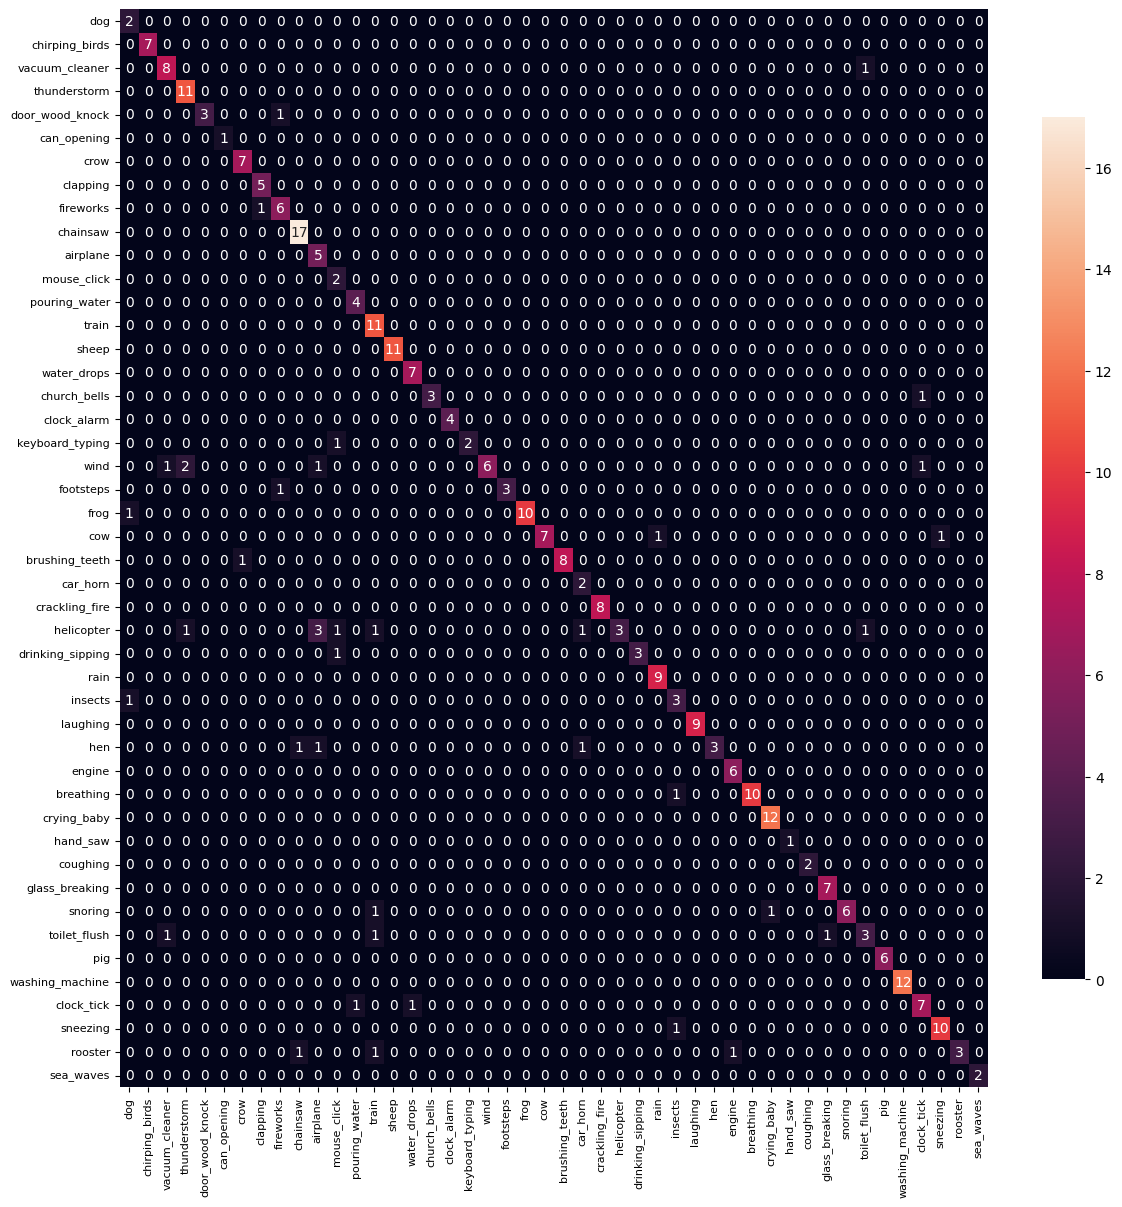

In [57]:
plt.figure(figsize=(14, 14))
sns.heatmap(cm, annot=True, xticklabels=chosen_labels, yticklabels=chosen_labels, annot_kws={"size": 10}, cbar_kws={'shrink': 0.8})
plt.xticks(fontsize=8);
plt.yticks(fontsize=8);

### grad data:
- grad_data[0] - class gradCAM means dictionary - values are tensors
- grad_data[1] - single gradCAM dictionary - values are lists of tensors
- drad_data[2] - class samples


In [ ]:
print(grad_data[0]['hand_saw'].shape)
print(len(grad_data[1]['hand_saw']))
print(grad_data[1]['dog'][0]) # shape:(1, 1, 64, 431)
print(grad_data[2]['dog'].shape)

(1, 1, 64, 431)
13
tensor([[[[0.6886, 0.6886, 0.6886,  ..., 0.0000, 0.0000, 0.0000],
          [0.6886, 0.6886, 0.6886,  ..., 0.0000, 0.0000, 0.0000],
          [0.6886, 0.6886, 0.6886,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]])
torch.Size([1, 64, 431])


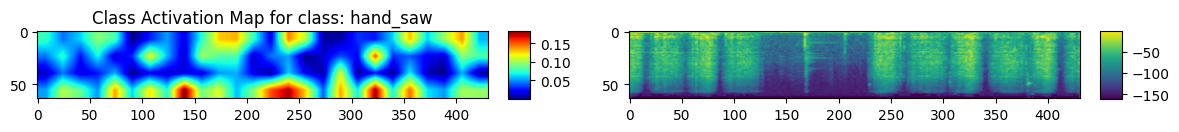

In [ ]:

fig, axs = plt.subplots(1, 2, figsize=(14, 7))
im = axs[0].imshow(grad_data[0]['hand_saw'][0,0,:,:], cmap='jet')
axs[0].set_title(f"Class Activation Map for class: {'hand_saw'}")
cbar = fig.colorbar(im, ax=axs[0], fraction=0.046, pad=0.04, aspect=3)  # Adjust colorbar size and aspect ratio
im2 = axs[1].imshow(grad_data[2]['hand_saw'][0,:,:])
axs[1].set_title(f"sample spectrogram for class: {'hand_saw'}")
cbar2 = fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04, aspect=3) 

#plt.savefig(f'cam_{key}.png')

In [ ]:
for key in class_cams.keys():
    plt.figure(figsize=(5, 10))
    plt.imshow(class_cams[key][0,0,:,:], cmap='jet')
    plt.title(f"Class Activation Map for class: {key}")
    #plt.colorbar()
    plt.show()
    #plt.savefig(f'cam_{key}.png')

# if save_output:
#     np.save('class_cams.npy', class_cams)

    # for key in class_cams.keys():
    #     plt.figure(figsize=(5, 10))
    #     plt.imshow(class_cams[key:[0,0,:,:], cmap='jet')
    #     plt.title(f"Class Activation Map for class: {key}")
    #     #plt.colorbar()
    #     plt.show()
    #     plt.savefig(f'cam_{key}.png')


